In [21]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV as LCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [22]:
#Notes:
#Determine if attacks can be grouped by type (DOS, User access, file delivery, portscan, etc)
    #Can named attacks be distinguished from each other within a type?
#Decide whether to remove or downsample DOS attacks...very unbalanced classes!
#Is it worth it to pursue cost/ease of mitigation vs. potential harm
#TCP vs UDP-UDP almost exclusively DOS attack
#3 models: Attack or not, Attack category, attack name
#SMURF is specific to ICMP
#Binary for UDP/ICMP? Or separate pipelines/models?



In [23]:
#talking points
#UDP different now (voip)
#ICMP should be thresholded, not necessarily modelled
#Different atk types for different protocols
#Services unclear, likely look much different now as well
#Poorly defined pre-engineered features
#Basically, we're trying to model on a model
#I don't have enough domain knowledge to derive the same or comparable features from the original dataset
#Attack types:
    #DOS
    #


In [24]:
#TODO:
#Pipeline:
    #get_dummies for flag and protocol
    #get_dummies and subset for service
#Train-test split!-stratify
    #separate dummies from numerical
    #standardscale numerical
    #Concat dummies back on
        #labelbinarizer on y_train, y_test if atk_categories
    #LassoCV fit - Class weight = Balanced?
#predict
#score
#calculate RMSE

#ROC/Profit curve?

##### Sources
https://www.sciencedirect.com/science/article/pii/S2352864817300810

http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

https://www.ll.mit.edu/ideval/docs/index.html


In [25]:
#Import as dataframe
cyberdf = pd.read_csv('cyberdata.gz', compression = 'infer', header = None)


In [26]:
# Set column names
cyberdf.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack']


In [27]:
len(cyberdf['attack'])

494021

In [28]:
#Create dict of categories and names of attacks
atks_by_cat = {'DOS': ['land.','neptune.','pod.','satan.','smurf.','teardrop.'],
               'U2R': ['buffer_overflow.','loadmodule.','perl.','rootkit.'],
               'R2L': ['ftp_write.','guess_passwd.','imap.','phf.'],
               'PRB': ['ipsweep.','nmap.','portsweep.'],
               'SEC': ['multihop.','warezclient.','warezmaster.','rootkit.','spy.'],
               'NRM': ['normal.']}

In [29]:
#Function to change dtype to categorical for object columns
def convert_cols_to_category(df, col_list):
    '''Takes a dataframe and a list of the columns to be converted
       and converts the dtype of the columns to 'category'
       to save memory space
    '''
    for c in col_list:
        try:
            df[c] = df[c].astype('category')
        except:
            print("Could not convert {} to categorical.".format(c))    

In [30]:
def drop_uniform_cols(df):
    '''Takes a dataframe and removes columns where col.min()==col.max()
    '''
    for c in df.columns:
        if df[c].min() == df[c].max():
            df.drop(c, axis = 1, inplace = True)

In [31]:
drop_uniform_cols(cyberdf)

In [32]:
cols = ['protocol_type','service','flag']
convert_cols_to_category(cyberdf, cols)

In [33]:
#Optional highly correlated cols to remove
drop_cols = ['dst_host_count', 'dst_host_same_src_port_rate', 'srv_diff_host_rate','count','hot','logged_in']
cyberdf.drop(drop_cols, axis = 1, inplace = True)

In [36]:
#create dfs for attack or not, attack category, attack name
y_n_df = cyberdf.copy()
atk_cats_df = cyberdf.copy()


In [37]:
atk_means = y_n_df.groupby('attack').mean()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,num_failed_logins,num_compromised,root_shell,su_attempted,...,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
attack,,,,,,,,,,,,,,,,,,,,,
back.,0.128915,54156.355878,8.232650e+03,0.00000,0.000000,0.000000,0.000000,0.966409,0.000000,0.000000,...,0.998847,0.002320,206.963686,1.000000,0.000000,0.000000,0.002138,0.002138,0.050390,0.050390
buffer_overflow.,91.700000,1400.433333,6.339833e+03,0.00000,0.000000,0.000000,0.000000,1.500000,0.600000,0.000000,...,0.917333,0.038000,13.900000,1.000000,0.000000,0.075000,0.000000,0.000000,0.021333,0.021333
ftp_write.,32.375000,220.750000,5.382250e+03,0.00000,0.000000,0.375000,0.000000,0.125000,0.000000,0.000000,...,1.000000,0.000000,22.750000,0.875000,0.250000,0.117500,0.000000,0.000000,0.000000,0.000000
guess_passwd.,2.716981,125.339623,2.161887e+02,0.00000,0.000000,0.000000,1.056604,0.000000,0.000000,0.000000,...,1.000000,0.000000,26.037736,1.000000,0.000000,0.018868,0.101509,0.101509,0.879245,0.879245
imap.,6.000000,347.583333,5.494867e+04,0.00000,0.000000,0.000000,0.000000,1.333333,0.000000,0.000000,...,1.000000,0.000000,5.583333,0.916667,0.000833,0.000000,0.572500,0.572500,0.002500,0.000000
ipsweep.,0.034483,10.083400,2.718524e-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,156.092221,0.930281,0.073777,0.602719,0.000000,0.000000,0.069118,0.066215
land.,0.000000,0.000000,0.000000e+00,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.920952,0.051429,4.238095,0.870000,0.026667,0.545238,0.893810,0.646667,0.006190,0.000000
loadmodule.,36.222222,151.888889,3.009889e+03,0.00000,0.000000,0.000000,0.000000,0.555556,0.333333,0.000000,...,0.880000,0.241111,3.555556,0.835556,0.205556,0.207778,0.000000,0.000000,0.000000,0.011111
multihop.,184.000000,435.142857,2.130163e+05,0.00000,0.000000,0.000000,0.000000,8.571429,0.285714,0.000000,...,1.000000,0.000000,1.571429,0.715714,0.002857,0.000000,0.000000,0.000000,0.011429,0.000000


In [39]:
#Replace values in y_n_df according to whether the traffic was normal or attack (0 for normal traffic)
y_n_df['attack'] = [0 if i == 'normal.' else 1 for i in y_n_df['attack']]

In [40]:
y_n_df['attack'].mean()

0.8030893423558918

In [41]:
#Replace values in atk_cats_df according to attack category dict
for i in atks_by_cat.items():
    atk_cats_df['attack'].replace(i[1], i[0], inplace = True)

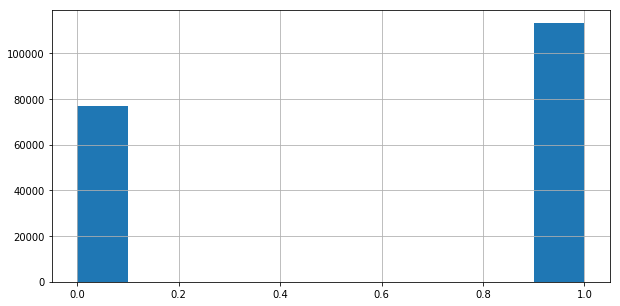

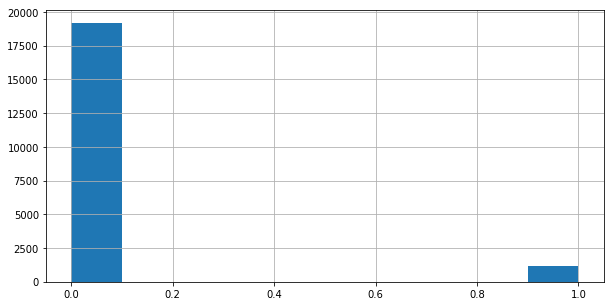

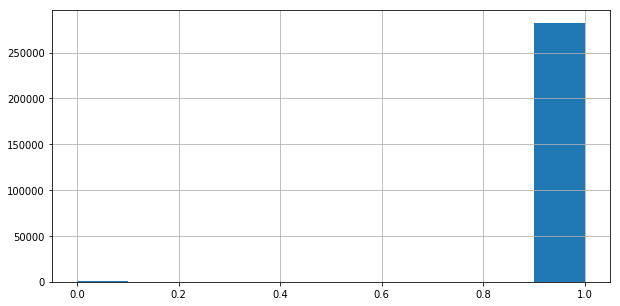

In [42]:
for p in ['tcp', 'udp', 'icmp']:
    y_n_df[y_n_df['protocol_type'] == p]['attack'].hist(figsize = (10,5))
    plt.show()

In [43]:
cyberdf[cyberdf['protocol_type'] == 'udp'].groupby(by = 'attack').count()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,num_failed_logins,...,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
attack,,,,,,,,,,,,,,,,,,,,,
nmap.,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
normal.,19177,19177,19177,19177,19177,19177,19177,19177,19177,19177,...,19177,19177,19177,19177,19177,19177,19177,19177,19177,19177
rootkit.,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
satan.,170,170,170,170,170,170,170,170,170,170,...,170,170,170,170,170,170,170,170,170,170
teardrop.,979,979,979,979,979,979,979,979,979,979,...,979,979,979,979,979,979,979,979,979,979


#### Attack Names
buffer_overflow,
ftp_write,
guess_passwd,
imap,
ipsweep,
land,
loadmodule,
multihop,
neptune,
nmap,
normal,
perl,
phf,
pod,
portsweep,
rootkit,
satan,
smurf,
spy,
teardrop,
warezclient,
warezmaster

#### Attack Categories
'DOS', 'U2R', 'R2L', 'PRB', 'SEC', 'NRM'

Denial of Service

User to Remote

Remote to Local (user)

Probe

Secret

Normal

#### Attack names by cat
'DOS': ['land','neptune','pod','satan','smurf','teardrop'],
'U2R': ['buffer_overflow','loadmodule','perl','rootkit'],
'R2L': ['ftp_write','guess_passwd','imap','phf'],
'PRB': ['ipsweep','nmap','portsweep'],
'SEC': ['multihop','warezclient','warezmaster','rootkit','spy']


#### Column names
'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate'

In [44]:
#Drop a few highly correlated columns
y_n_df = y_n_df.drop(['rerror_rate','srv_rerror_rate','serror_rate','dst_host_serror_rate'], axis = 1)

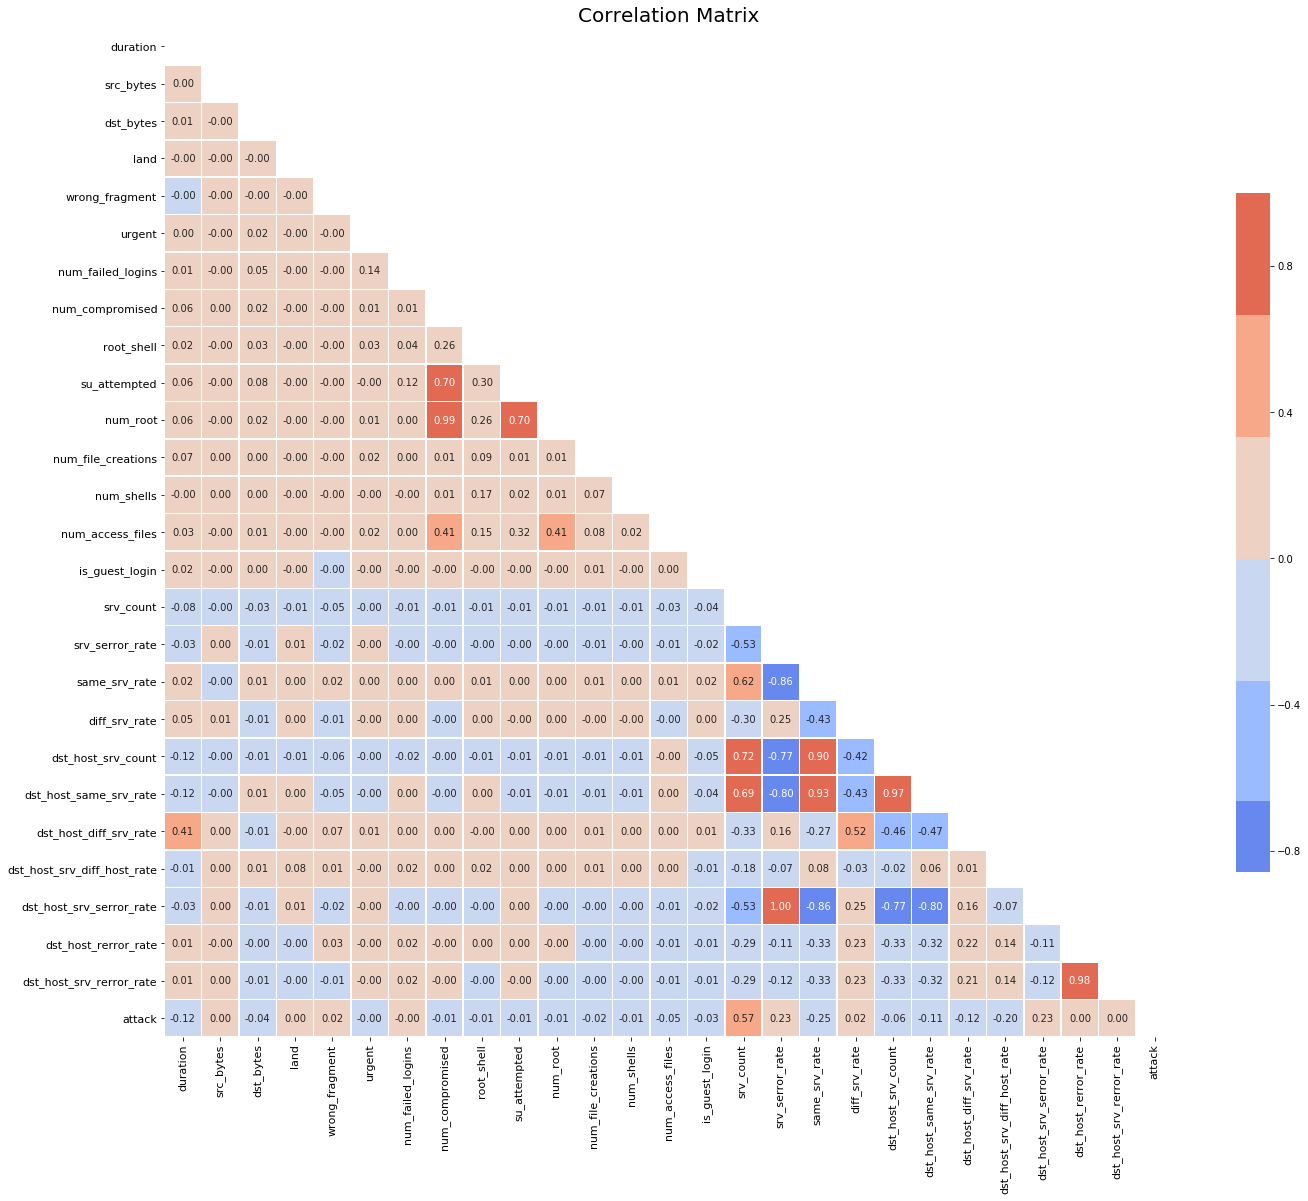

In [45]:
def correlation_heatmap(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(20,20))
    cmap = sns.color_palette('coolwarm')
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
                yticklabels=True, annot=True, fmt='.2f', cbar_kws={'shrink':.5})
    plt.title('Correlation Matrix', fontsize=20)
    plt.xticks(rotation=90, fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
correlation_heatmap(y_n_df)

In [46]:
#Pipeline:
    #get_dummies for flag and protocol
    #get_dummies and subset for service
        #Use correlation to decide which services to keep/remove
#Train-test split!-stratify
    #separate dummies from numerical
    #standardscale numerical
    #Concat dummies back on
        #labelbinarizer on y_train, y_test if atk_categories
    #LassoCV fit - Class weight = Balanced?
#predict
#score
#calculate RMSE

#ROC/Profit curve?

In [47]:
#Remove categoricals, standardscale continuous, then concat categoricals
cat_cols = ['protocol_type','flag','service', 'attack']
cat_df = y_n_df[cat_cols]
contdf = y_n_df.drop(cat_cols, axis = 1)
ssc = StandardScaler()
ssc.fit(contdf)
y_n_standardized = pd.DataFrame(ssc.transform(contdf), columns = contdf.columns)
standardized_with_targets = pd.concat([y_n_standardized, cat_df['attack']], axis = 1)
y_n_standardized = pd.concat([y_n_standardized, cat_df], axis = 1)

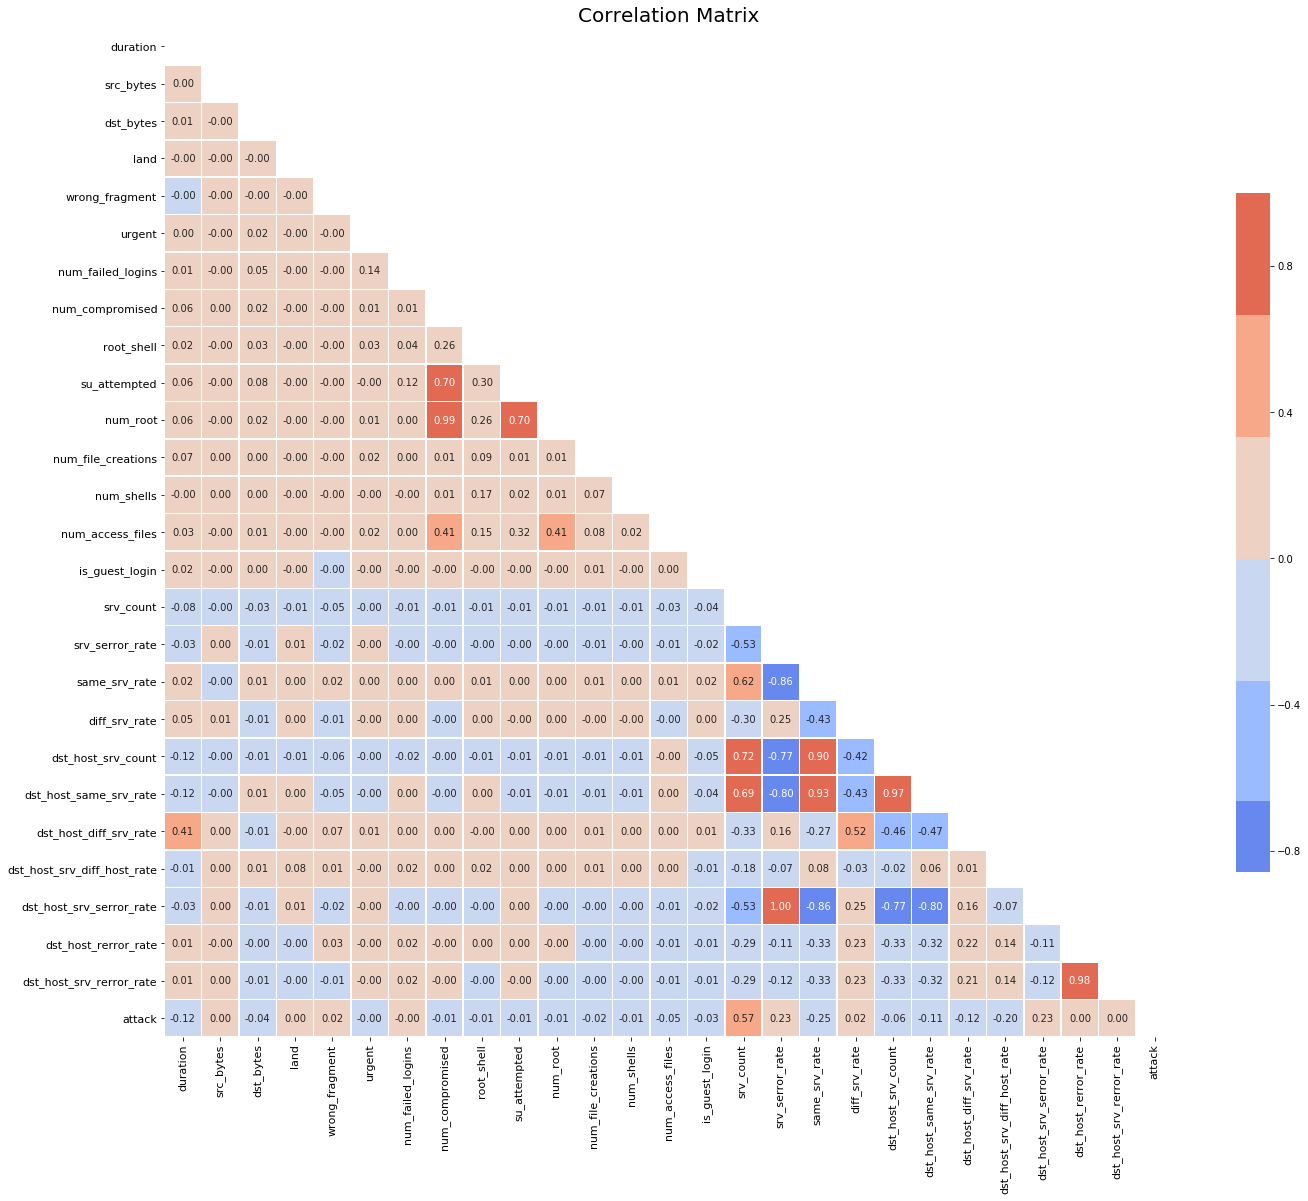

In [48]:
correlation_heatmap(standardized_with_targets)

In [49]:
y_n_standardized.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,flag,service,attack
0,-0.067792,-0.002879,0.138664,-0.006673,-0.04772,-0.002571,-0.009782,-0.005679,-0.010552,-0.004676,...,0.599396,-0.282867,-0.158629,-0.463202,-0.25204,-0.249464,tcp,SF,http,0
1,-0.067792,-0.002820,-0.011578,-0.006673,-0.04772,-0.002571,-0.009782,-0.005679,-0.010552,-0.004676,...,0.599396,-0.282867,-0.158629,-0.463202,-0.25204,-0.249464,tcp,SF,http,0
2,-0.067792,-0.002824,0.014179,-0.006673,-0.04772,-0.002571,-0.009782,-0.005679,-0.010552,-0.004676,...,0.599396,-0.282867,-0.158629,-0.463202,-0.25204,-0.249464,tcp,SF,http,0
3,-0.067792,-0.002840,0.014179,-0.006673,-0.04772,-0.002571,-0.009782,-0.005679,-0.010552,-0.004676,...,0.599396,-0.282867,-0.158629,-0.463202,-0.25204,-0.249464,tcp,SF,http,0
4,-0.067792,-0.002842,0.035214,-0.006673,-0.04772,-0.002571,-0.009782,-0.005679,-0.010552,-0.004676,...,0.599396,-0.282867,-0.158629,-0.463202,-0.25204,-0.249464,tcp,SF,http,0


In [50]:
#One-Hot encode Categorical features
y_n_standardized = pd.get_dummies(y_n_standardized, columns = ['protocol_type','flag','service'])
#dummydfno_srv = pd.get_dummies(y_n_df, columns = ['protocol_type','flag'])

In [51]:
#Stratified Train Test Split
y = y_n_standardized['attack']
X = y_n_standardized.drop('attack', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)



In [52]:

#Fit a 3-fold logistic cross-validated model with L1 (lasso) penalty
mod = LogisticRegression(penalty = 'l1', class_weight = 'balanced')
mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
#Score with l2 penalty, balanced weight
mod.score(X_test, y_test)

0.98912603436270308

In [54]:
y_pred = mod.predict(X_test)

In [55]:
print('F1 score: {}\nPrecision Score: {} \nRecall Score: {}\nROC_AUC Score: {}'.format(f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), roc_auc_score(y_test, y_pred)))

F1 score: 0.9931960381994579
Precision Score: 0.9981873542500432 
Recall Score: 0.9882543907406287
ROC_AUC Score: 0.9904676558966302


In [56]:
#Score with l1 penalty, balanced weight
mod.score(X_test, y_test)

0.98912603436270308

In [57]:
fpr, tpr, thresh = roc_curve(y_test, y_pred)

In [58]:
tpr

array([ 0.        ,  0.98825439,  1.        ])

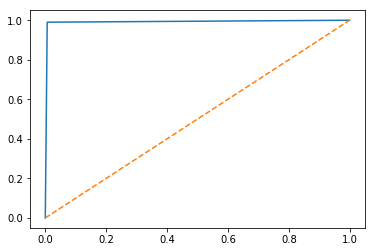

In [157]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0,1],[0,1], '--');

In [60]:
testing = pd.read_csv('cyberdata.gz', compression = 'infer', header = None)

In [61]:
testing.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
